# S pol flight experiments

Trying to compare S pol flights with other flights to get an idea of the impact of drone polarization

In [1]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import pickle, glob, yaml, string
from os import path

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from scipy.stats import binned_statistic_2d

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
import beamcals.beam_autoprocessing as ba
from beamcals.sites import site
import beamcals.reduce_ccclass as rc

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

# various gridding attempts
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'

## Laura's functions

In [2]:
def get_flightinfo(fly):
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

def get_beam_diff(beam2, beam1,n):
    return beam2[:,:] - n*beam1[:,:]

def get_stat(new_d,whstat='stddev'): # default is stddev
    diff_flat = np.ndarray.flatten(new_d)
    if whstat=='stddev':
        stat = np.nanstd(diff_flat)
    elif whstat=='median':
        # compute median
        stat = np.abs(np.nanmedian(diff_flat))
    elif whstat=='sum':
        stat = np.nanmean(np.abs(diff_flat))
    elif whstat=='mednoabs':
        stat = np.nanmedian(diff_flat)
    return stat

def get_slice_old(beam,Z,val,ax='x'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[0,1,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[0,:,0])
    ok = True
    while(ok):
        if ax=='x':
            col = np.where((beam.x_centers_grid[0,:,0] < val+tol) & (beam.x_centers_grid[0,:,0] > val-tol))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        if ax=='y':
            col = np.where((beam.y_centers_grid[:,0,0] < val+tol) & (beam.y_centers_grid[:,0,0] > val-tol))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=3
        if tol > 30: ok = False
    return col

def get_slice_anyin(LX,LY,val,ax='x'):
    tol = abs(LX[0,1] - LX[0,0])/1.5
    if ax=='x':
        col = np.where((LX[0,:] < val+tol) & (LX[0,:] > val-tol))[0][0]
    if ax=='y':
        col = np.where((LY[:,0] < val+tol) & (LY[:,0] > val-tol))[0][0]
    return col

def get_slice(beam,Z,val, sliceOrientation='h'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[1,0,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[:,0,0]) #figure out the importance of this 
    ok = True
    while(ok):
        if sliceOrientation=='h': #keeping the y value constant and changing the x value 
            sliceIndex = np.where((beam.y_centers_grid[0,:,0] < (val + tol)) & (beam.y_centers_grid[0,:,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
                #still need to do this one 
        if sliceOrientation=='v':#keeping the x value constant and changing the y value 
            sliceIndex = np.where((beam.x_centers_grid[:,0,0] < (val+tol)) & (beam.x_centers_grid[:,0,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=1
        if tol > 30: ok = False
    return sliceIndex[0]


def get_concatlist(flights):
    #for i, fly in enumerate(flights):
    pickle_directory='/hirax/GBO_Analysis_Outputs/flight_pickles/'
    concytest=[glob.glob(pickle_directory+'*'+fly+'*')[0] for fly in flights]
    return concytest

##  reads in flights

In [3]:
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

print(len(flights))

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))
print(gfitarr,amparr)


# SLICE DEFAULTS # 
sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

# PLOTTING DEFAULT # 
cmap = matplotlib.cm.get_cmap('gnuplot2')
norm = matplotlib.colors.Normalize(vmin=-25, vmax=25)
sfig = False

Npolflights = ['619','625']
Spolflight = ['623']

13
['FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz'
 'FLY534_20210826T185621Z_2dGauss_and_Airy_Params.npz'
 'FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz'
 'FLY536_20210826T195003Z_2dGauss_and_Airy_Params.npz'
 'FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz'
 'FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz'
 'FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz'
 'FLY623_20211021T203206Z_2dGauss_and_Airy_Params.npz'
 'FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz'
 'FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz'
 'FLY647_20211022T185749Z_2dGauss_and_Airy_Params.npz'
 'FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz'
 'FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz'] ['FLY533_Corrected_amplitudes.pkl' 'FLY534_Corrected_amplitudes.pkl'
 'FLY535_Corrected_amplitudes.pkl' 'FLY536_Corrected_amplitudes.pkl'
 'FLY619_Corrected_amplitudes.pkl' 'FLY623_Corrected_amplitudes.pkl'
 'FLY625_Corrected_amplitudes.pkl' 'FLY646_Corrected_amplitudes.pkl'
 'FLY

In [4]:
# In this cell I use a special (soon to be deprecated, Nov 2023) beam class
# this one happens to give real error bars as the stddev across all data in pixel

# Lets look at only the N-pol flights at the same attenuation, pick one frequency

Npolflights = ['618','619','625']

pflights=Npolflights
find=900

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for fly in pflights]


beam=ba.Beammap_forautoprocessing(concatlist=concytest,
                 normalization='Gauss_wcorr',operation='std',mask=True,Xargs=[-1*sz,sz,2.5],
                 Yargs=[-1*sz,sz,2.5],Fargs=[find,find+1,1])


start of big ass loop is: 2023-11-09 21:46:36.823468
618 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
625 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2023-11-09 21:46:46.510795   


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beam_autoprocessing.py:173: RuntimeWarning: invalid value encountered in true_divide
  self.V_LC_operation = np.nansum(self.V_LC_sum,axis=4)/self.V_LC_operation_count


618 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
625 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beam_autoprocessing.py:216: RuntimeWarning: invalid value encountered in true_divide
  self.V_LC_operation_err = (np.nansum(self.V_LC_err,axis=4)/self.V_LC_operation_count)**0.5 # stddev


<ipython-input-5-3e5b12953753>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],


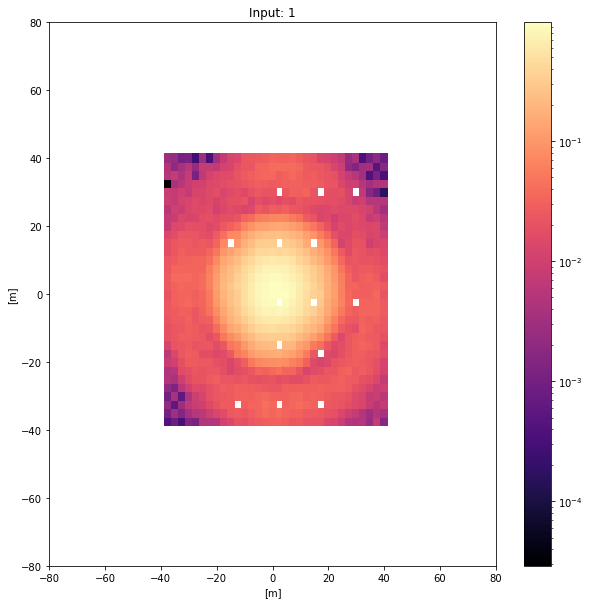

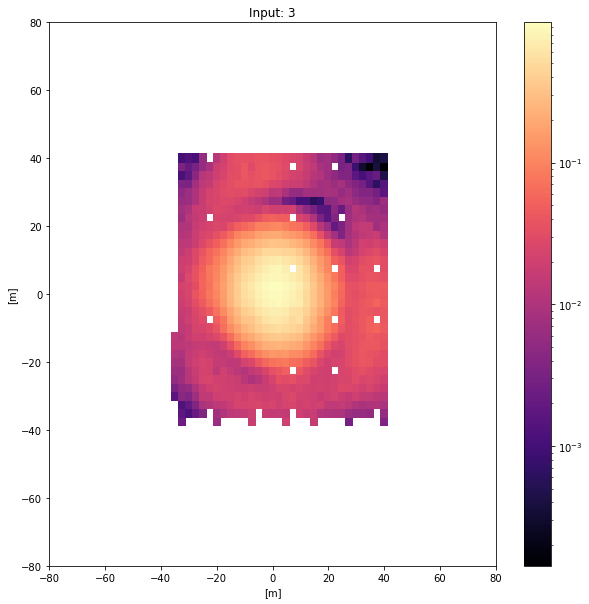

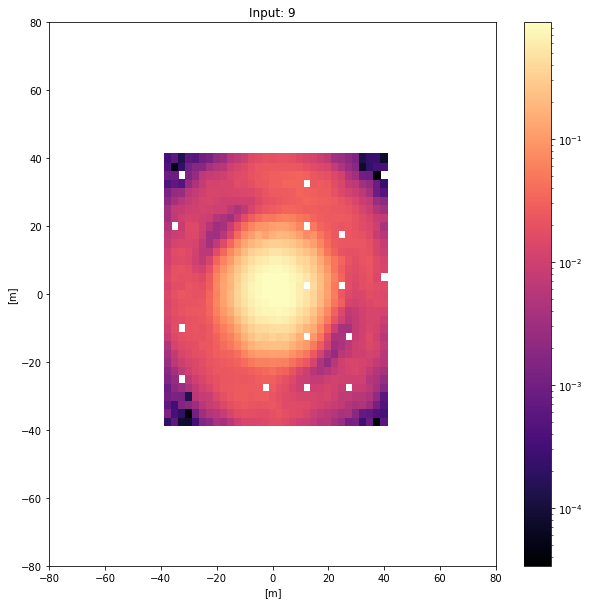

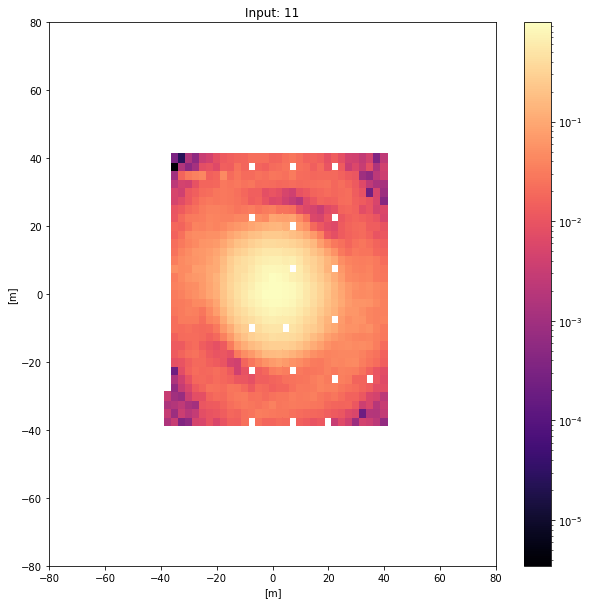

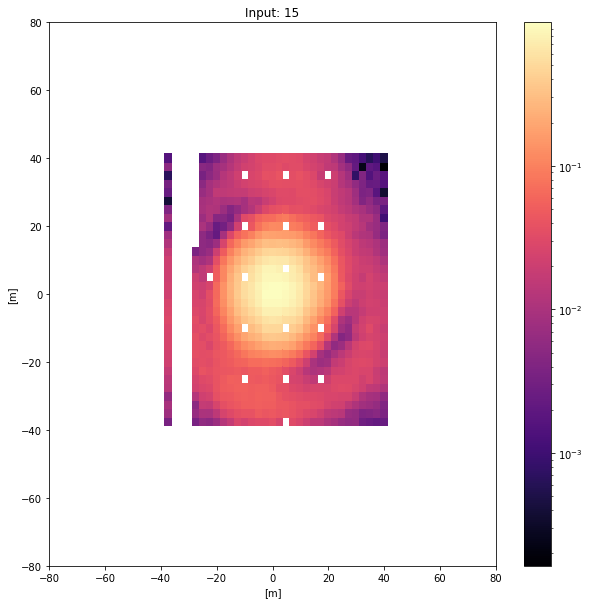

<ipython-input-5-3e5b12953753>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],


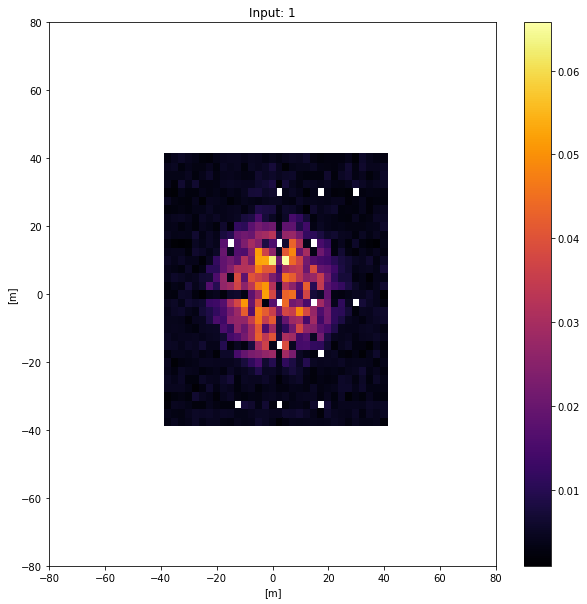

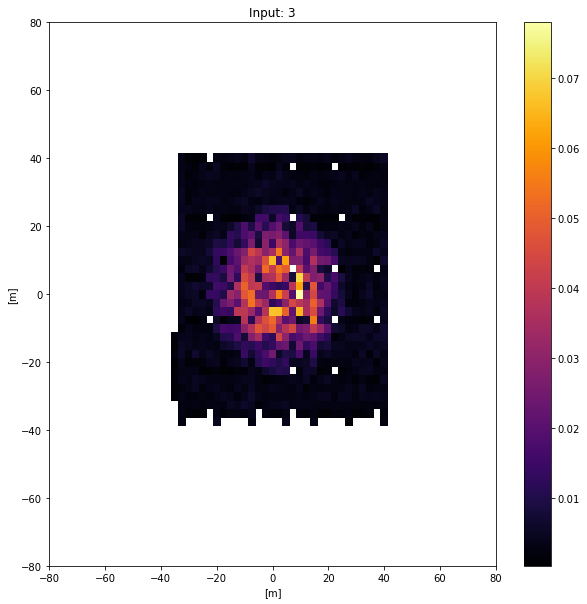

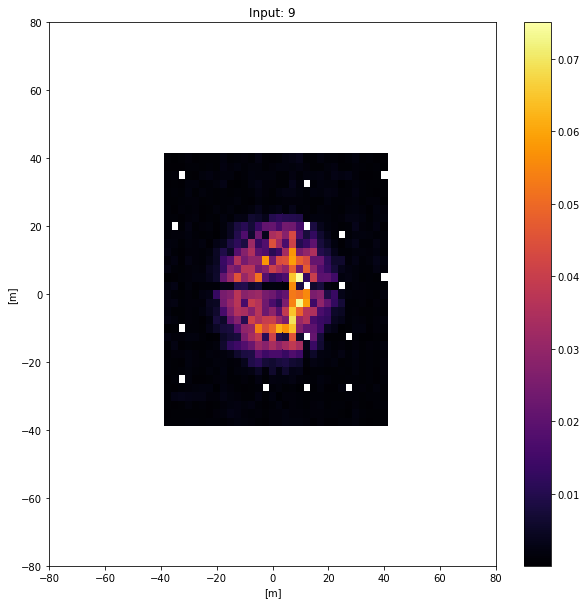

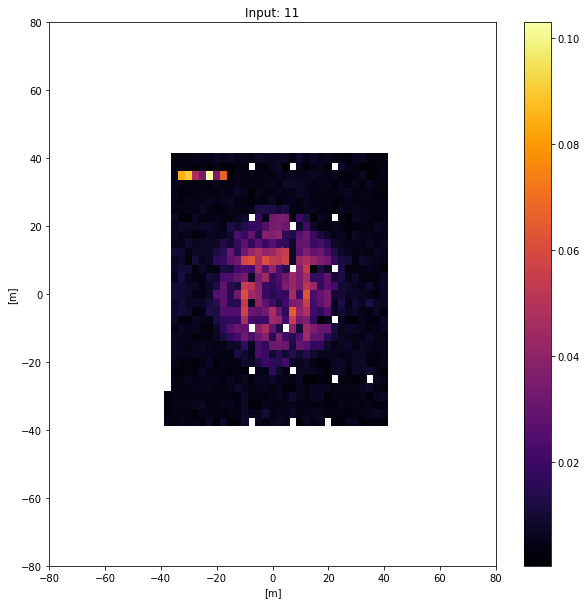

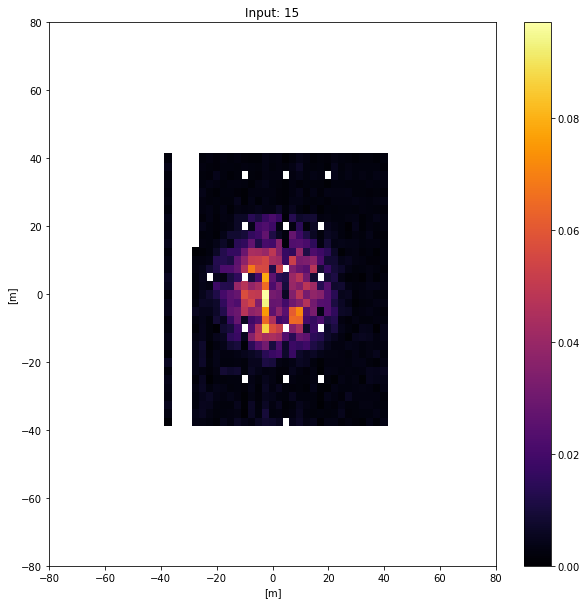

In [5]:
# Here let's just plot the beams and variances per input as a quick check

pols = N_pols

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               np.abs(beam.V_LC_operation[:,:,0,chind]),cmap=cm.magma,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               beam.V_LC_operation_err[:,:,0,chind],cmap=cm.inferno)#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

In [6]:
# Now let's read in flight 623 and apply the Gaussian normalization. 
# We'll also read in the correction based on matching sidelobes, and apply it

fly='623'

pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)


fl623_grided=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                 normalization='Gauss',operation='coadd',Xargs=[-1*sz,sz,2.5],
                 Yargs=[-1*sz,sz,2.5],Fargs=[find,find+1,1],f_index=find,vplot=False)


pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
with open(pklfile, 'rb') as inp:
    amps = pickle.load(inp)
    
fl623 = fl623_grided.V_LC_mean[:,:,0,:,0]*amps[0,find,:]

623 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
start of big ass loop is: 2023-11-09 21:47:02.669766
end of chan/freq loop is: 2023-11-09 21:47:07.128468       


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beammap.py:329: RuntimeWarning: Mean of empty slice
  self.V_LC_operation=np.nanmean(self.V_LC_mean,axis=4)


AttributeError: 'Beammap_forautoprocessing' object has no attribute 'V_LC_mean'

<ipython-input-10-22a79f940c64>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(fl623_grided.x_centers_grid[:,:,chind],fl623_grided.y_centers_grid[:,:,chind],


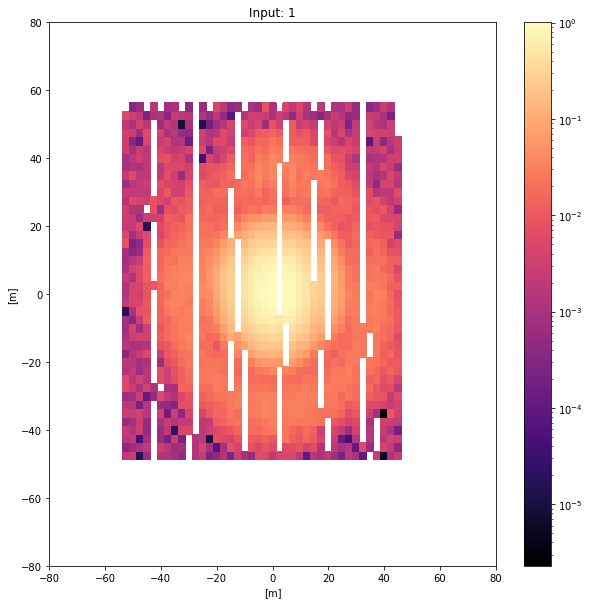

<ipython-input-10-22a79f940c64>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],


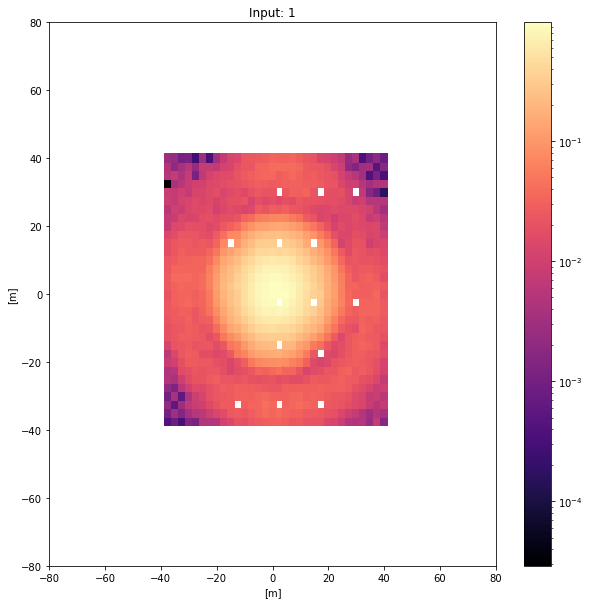

<ipython-input-10-22a79f940c64>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],


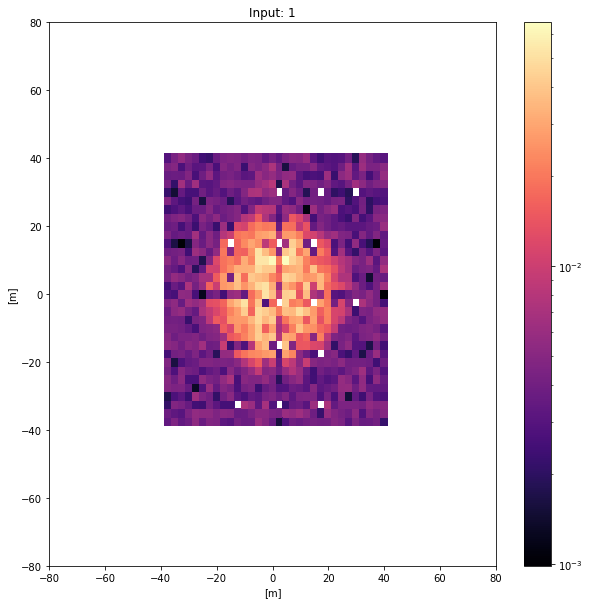

<ipython-input-10-22a79f940c64>:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],


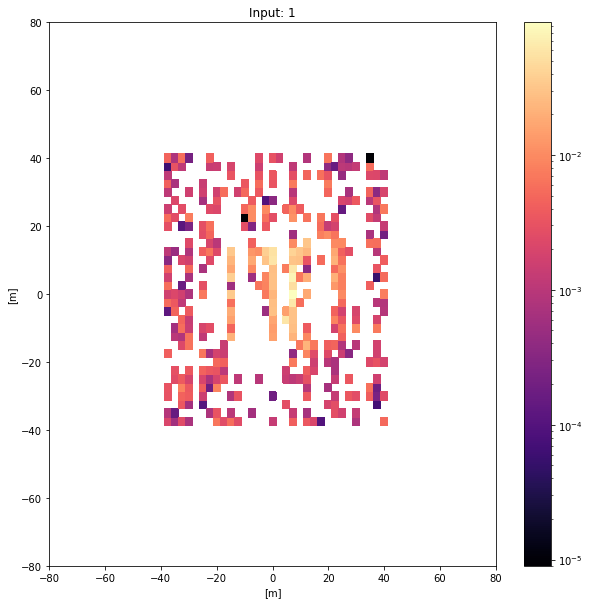

<ipython-input-10-22a79f940c64>:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],


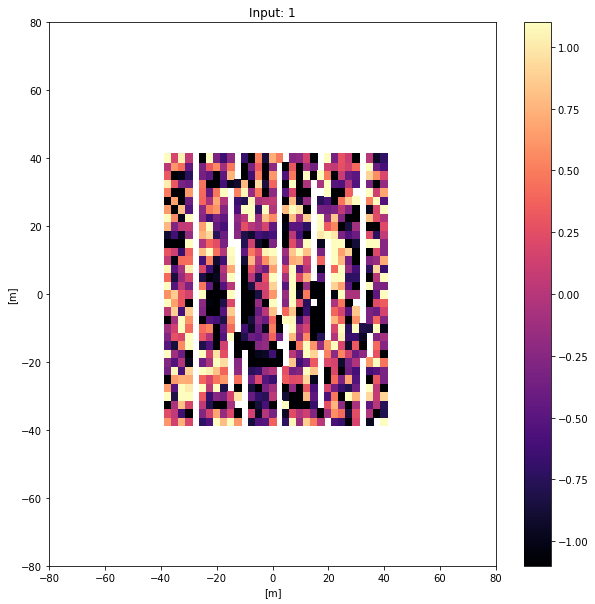

In [10]:
# Lets plot, for one channel, the two beams, the difference, and the difference/variance
chind = 1

# plot flight 623
fig = plt.figure(figsize=(10,10))
plt.pcolormesh(fl623_grided.x_centers_grid[:,:,chind],fl623_grided.y_centers_grid[:,:,chind],
               np.abs(fl623_grided.V_LC_mean[:,:,0,chind,0]),cmap=cm.magma,norm=LogNorm())#,edgecolors='k')
plt.xlim(-1*sz,sz)
plt.ylim(-1*sz,sz)
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.title('Input: '+str(chind))
plt.colorbar()
plt.show()

# plot the co-added flight
fig = plt.figure(figsize=(10,10))
plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               np.abs(beam.V_LC_operation[:,:,0,chind]),cmap=cm.magma,norm=LogNorm())#,edgecolors='k')
plt.xlim(-1*sz,sz)
plt.ylim(-1*sz,sz)
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.title('Input: '+str(chind))
plt.colorbar()
plt.show()

# plot the variance

fig = plt.figure(figsize=(10,10))
plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               np.abs(beam.V_LC_operation_err[:,:,0,chind]),cmap=cm.magma,norm=LogNorm())#,edgecolors='k')
plt.xlim(-1*sz,sz)
plt.ylim(-1*sz,sz)
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.title('Input: '+str(chind))
plt.colorbar()
plt.show()
    
# plot the difference

fig = plt.figure(figsize=(10,10))
plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               fl623_grided.V_LC_mean[:,:,0,chind,0] - beam.V_LC_operation[:,:,0,chind],cmap=cm.magma,norm=LogNorm())#,edgecolors='k')
plt.xlim(-1*sz,sz)
plt.ylim(-1*sz,sz)
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.title('Input: '+str(chind))
plt.colorbar()
plt.show()

# plot the difference over the variance
fig = plt.figure(figsize=(10,10))
plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               (fl623_grided.V_LC_mean[:,:,0,chind,0] - beam.V_LC_operation[:,:,0,chind])/beam.V_LC_operation_err[:,:,0,chind],
               cmap=cm.magma,vmax=1.1,vmin=-1.1)#,edgecolors='k')
plt.xlim(-1*sz,sz)
plt.ylim(-1*sz,sz)
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.title('Input: '+str(chind))
plt.colorbar()
plt.show()


<ipython-input-18-8f2d4f7a4e0e>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],


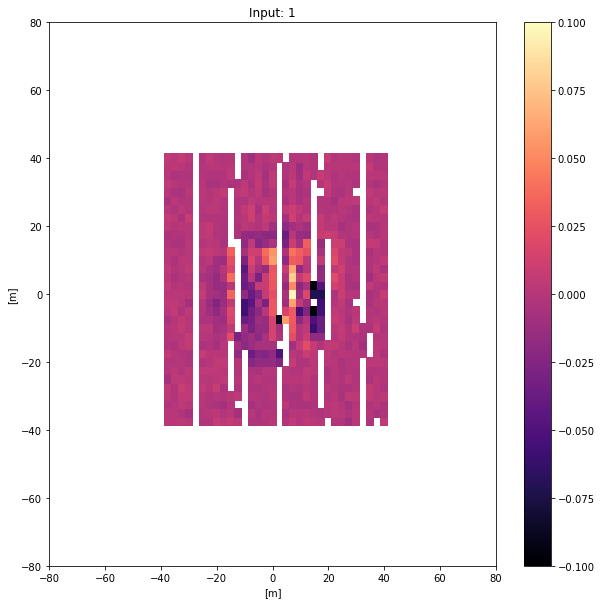

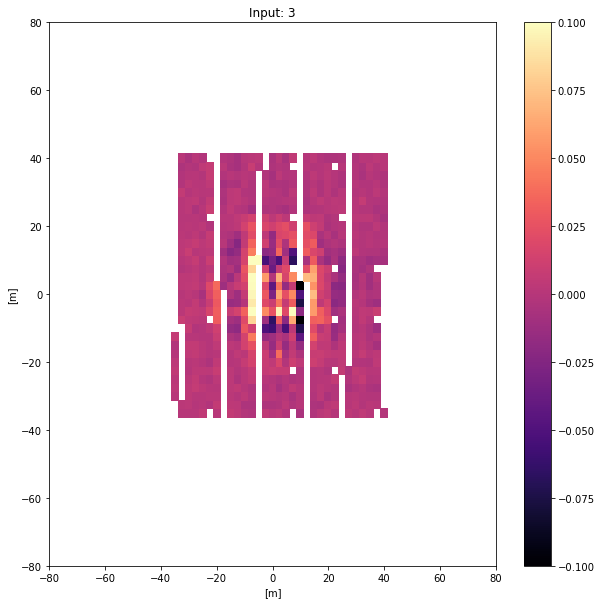

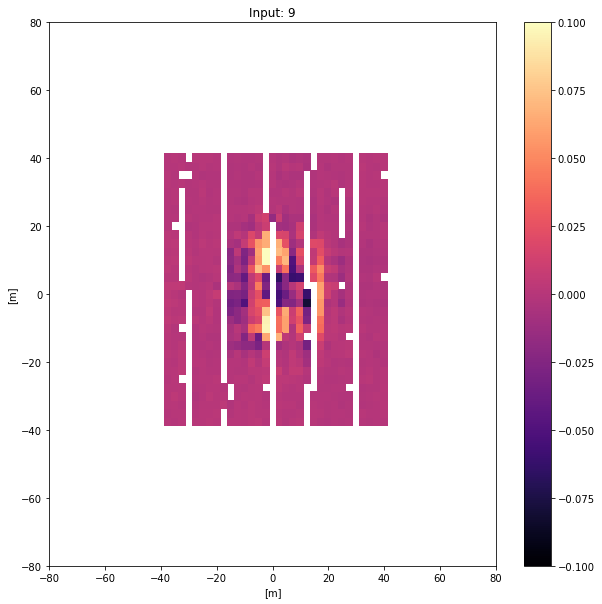

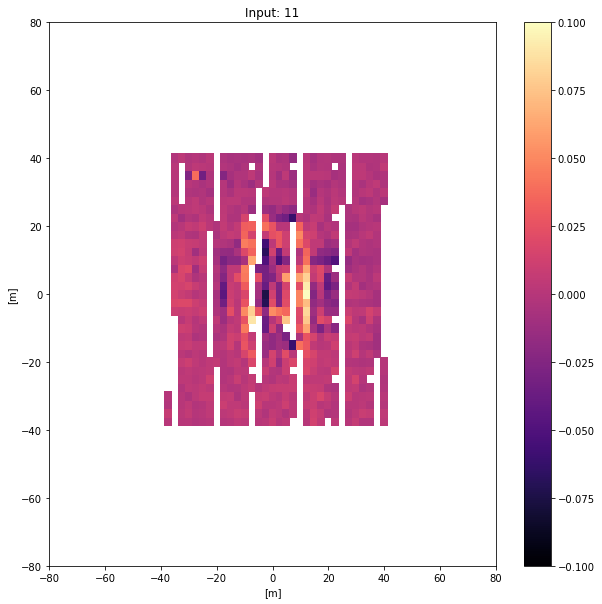

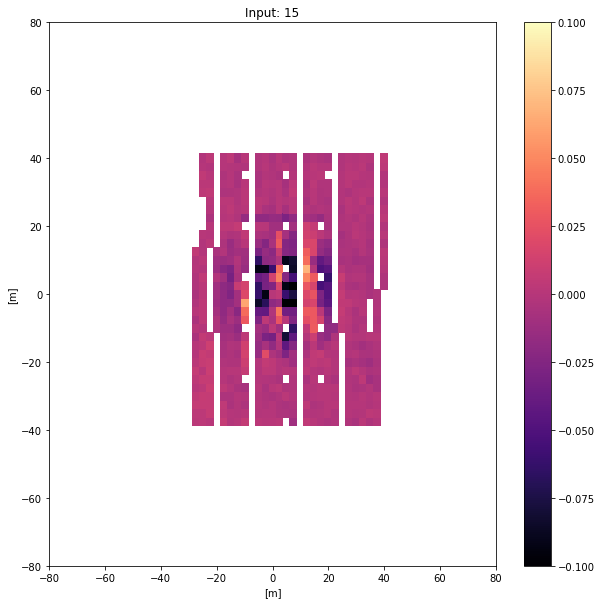

<ipython-input-18-8f2d4f7a4e0e>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],


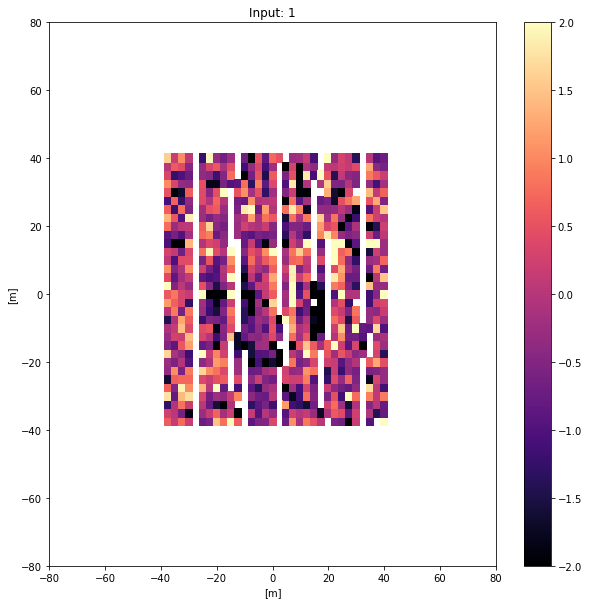

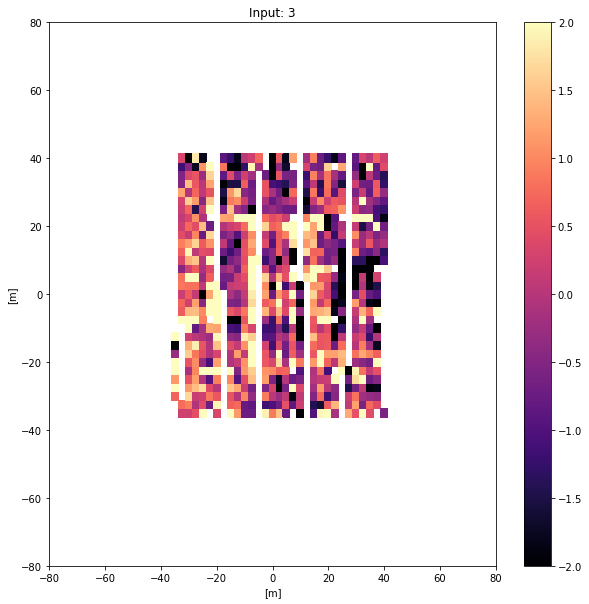

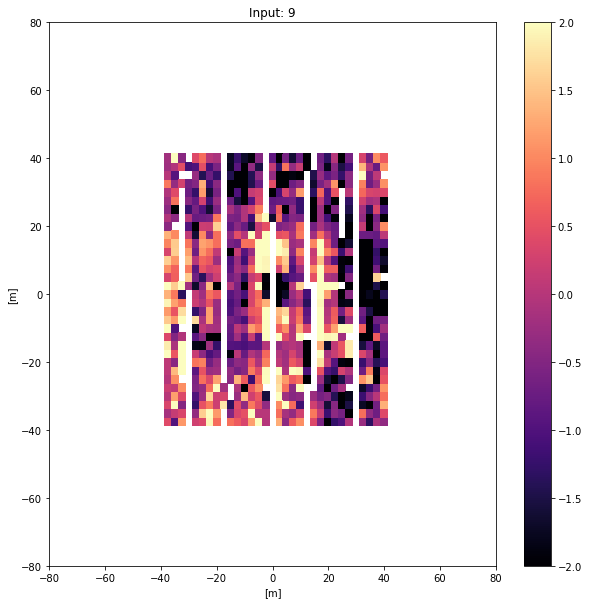

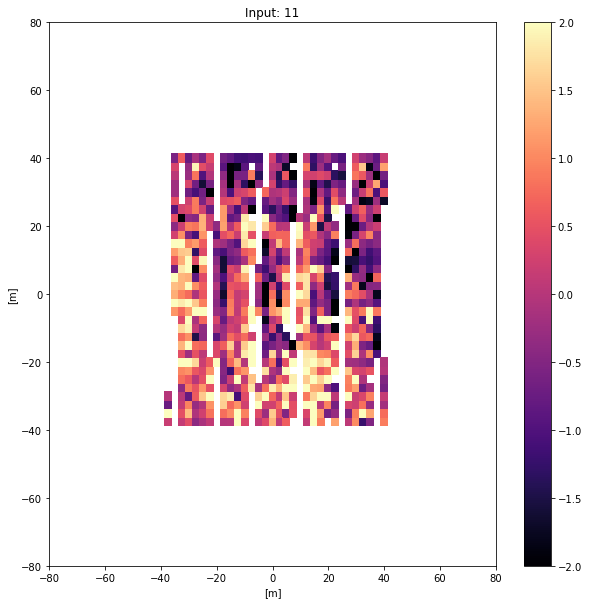

<ipython-input-18-8f2d4f7a4e0e>:17: RuntimeWarning: divide by zero encountered in true_divide
  (fl623_grided.V_LC_mean[:,:,0,chind,0] - beam.V_LC_operation[:,:,0,chind])/beam.V_LC_operation_err[:,:,0,chind],


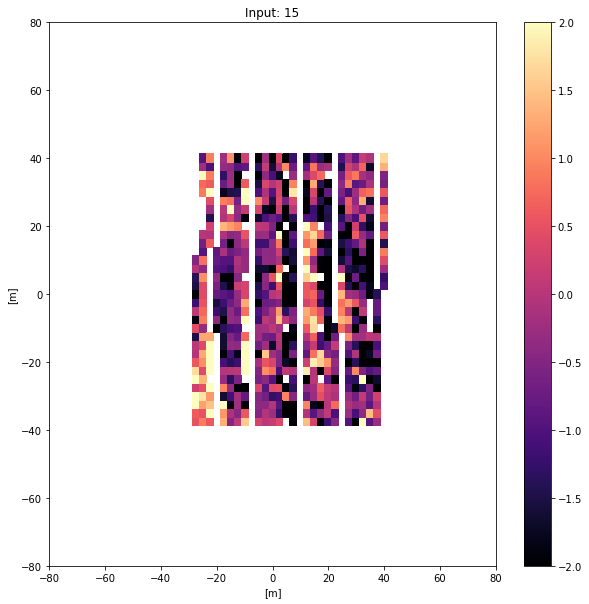

In [18]:
# Ltat looks pretty good, lets plot the differences for all the channels
# and the differences over the variance

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               (fl623_grided.V_LC_mean[:,:,0,chind,0] - beam.V_LC_operation[:,:,0,chind]),
               cmap=cm.magma,vmin=-0.1,vmax=0.1)#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()
    
for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               (fl623_grided.V_LC_mean[:,:,0,chind,0] - beam.V_LC_operation[:,:,0,chind])/beam.V_LC_operation_err[:,:,0,chind],
               cmap=cm.magma,vmax=2.0,vmin=-2.0)#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

<ipython-input-34-f9abd9f1f3bd>:3: RuntimeWarning: divide by zero encountered in true_divide
  diffovererr = diff/beam.V_LC_operation_err[:,:,0,inputs]
<ipython-input-34-f9abd9f1f3bd>:5: RuntimeWarning: Mean of empty slice
  s_diff = np.nanmean(diff,axis=-1)
<ipython-input-34-f9abd9f1f3bd>:6: RuntimeWarning: Mean of empty slice
  s_diff_oe = np.nanmean(diffovererr,axis=-1)
<ipython-input-34-f9abd9f1f3bd>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],


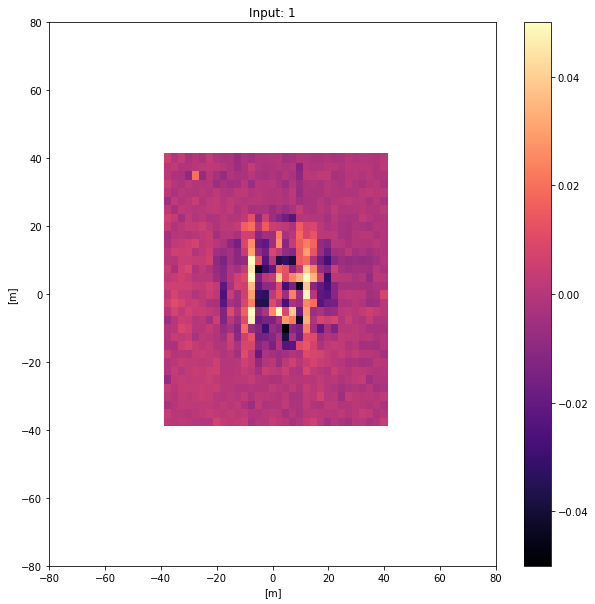

<ipython-input-34-f9abd9f1f3bd>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],


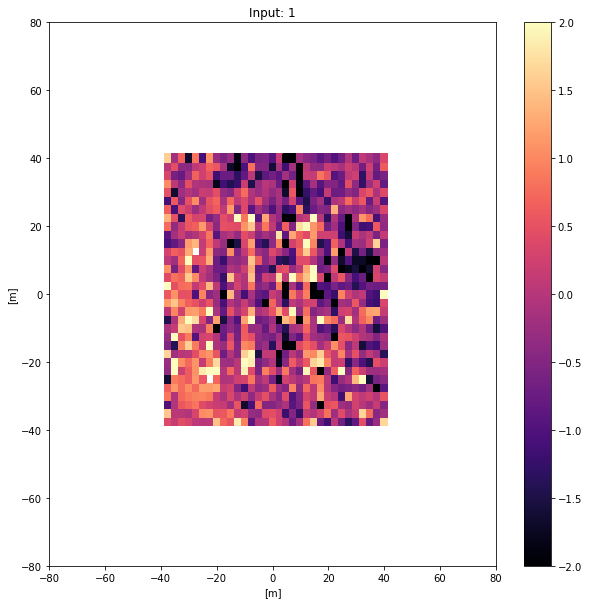

In [34]:
# above, input 9 looked odd. If we are looking for drone systematics, which should be common to all dishes
# we don't want to be driven by one strange dish. Let's exclude, and then average the differences, and
# average the differences over the variances, to see if we 'integrate' a systematic back out

inputs=[1,3,11,15]
diff = fl623_grided.V_LC_mean[:,:,0,inputs,0] - beam.V_LC_operation[:,:,0,inputs]
diffovererr = diff/beam.V_LC_operation_err[:,:,0,inputs]

s_diff = np.nanmean(diff,axis=-1)
s_diff_oe = np.nanmean(diffovererr,axis=-1)

fig = plt.figure(figsize=(10,10))
plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               s_diff,cmap=cm.magma,vmin=-0.05,vmax=0.05)#,edgecolors='k')
plt.xlim(-1*sz,sz)
plt.ylim(-1*sz,sz)
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.colorbar()
plt.show()
    
fig = plt.figure(figsize=(10,10))
plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               s_diff_oe, cmap=cm.magma,vmax=2.0,vmin=-2.0)#,edgecolors='k')
plt.xlim(-1*sz,sz)
plt.ylim(-1*sz,sz)
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.colorbar()
plt.show()

Text(0.5, 0.98, 'Frequency 448.4375 MHz')

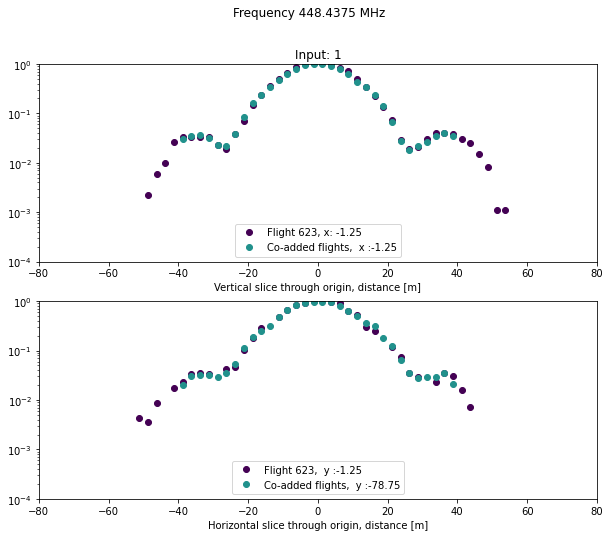

In [30]:
# For fun, lets plot a slice of the coadded vs flight 623 slice 
# ideally would add error bars from the variance

colors=pu.cm_to_discrete('viridis', 3)

xx = 0
chind = pols[0]
colx = get_slice(fl623_grided,fl623_grided.V_LC_mean[:,:,0,chind,0],xx,'v')
coly = get_slice(fl623_grided,fl623_grided.V_LC_mean[:,:,0,chind,0],xx,'h')

fig = plt.figure(figsize=(10,8))
plt.subplot(2,1,1)

plt.semilogy(fl623_grided.y_centers_grid[colx,:,0],fl623[colx,:,chind],'o',
             color=colors[0],label='Flight 623, x: '+str(fl623_grided.x_centers_grid[colx,0,0]))
plt.semilogy(fl623_grided.y_centers_grid[colx,:,0],beam.V_LC_operation[colx,:,0,chind],'o',
             color=colors[1],label='Co-added flights,  x :'+str(fl623_grided.x_centers_grid[colx,0,0]))
plt.title('Input: '+str(chind))
plt.ylim(0.0001,1)
plt.xlim(-1*sz,sz)
plt.xlabel('Vertical slice through origin, distance [m]')
plt.legend(loc='lower center')

plt.subplot(2,1,2)
plt.semilogy(fl623_grided.x_centers_grid[:,coly,0],fl623[:,coly,chind],'o',
             color=colors[0],label='Flight 623,  y :'+str(fl623_grided.y_centers_grid[0,coly,0]))
plt.semilogy(fl623_grided.x_centers_grid[:,coly,0],beam.V_LC_operation[:,coly,0,chind],'o',
             color=colors[1],label='Co-added flights,  y :'+str(fl623_grided.x_centers_grid[0,coly,0]))
plt.ylim(0.0001,1)
plt.xlim(-1*sz,sz)
plt.xlabel('Horizontal slice through origin, distance [m]')
plt.legend(loc='lower center')
plt.suptitle('Frequency '+str(freqs[find])+' MHz')

In [ ]:
## BELOW IS ANAs ORIGINAL CODE ## 

In [ ]:
for find in good_freqs[::10]:
    print('Working on Frequency: ',find,freqs[find])

#     flights = Npolflights
    flightinfo=[]
    for i,flight in enumerate(Npolflights):
        flightdict={}
        flightdict['vpol'],flightdict['pols'],flightdict['cpols'],flightdict['attn'],flightdict['fi']=get_flightinfo(flight)
        flightinfo.append(flightdict)
    print(flightinfo)
    
    print(pcklarr)
    
    # beam fits
#     vpol, pols, cpols, attn, fi = get_flightinfo(fly1)
    concytest=[pcklarr[5],pcklarr[8]]
    print(concytest)
    
    gfit_directory='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
    gfitlist=[path.basename(glob.glob(gfit_directory+'*'+FLYNUM+'*.npz')[0])for FLYNUM in Npolflights]
    print(gfitlist)
    
#     concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for fly in Npolflights]
    
    ampcorr_directory='/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
    ampcorr=[(glob.glob(ampcorr_directory+'*'+FLYNUM+'*.pkl'))[0] for FLYNUM in Npolflights]    
    print(ampcorr)
    
#    amplitude correction
#     for fly in Npolflights[1::]:
#     thingy=[]
#     amps = np.zeros([4,1024,16]) # stat [best amp value from median, median value at min, best from stdd, best from mean], freq, dish

#     apkls = glob.glob(ampdir+'*'+FLYNUM+'*.pkl')[0]
#     with open(apkls, 'rb') as inp:
#         ampdata = pickle.load(inp)
    
#     for p in pols:
#         thingy.append(np.nanmedian(ampdata[good_freqs,p],axis=0))
#     print('Flight: ',fly,' Amplitude Correction: ', np.nanmedian(thingy))
    
#     concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for fly in flights]


#     beam1=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
#                  normalization='Gauss_wcorr',operation='coadd',mask=True,Xargs=[-1*sz,sz,1.0],
#                  Yargs=[-1*sz,sz,1.5],Fargs=[find-1,find+1,1],f_index=find)
    
#     beam=ba.Beammap_forautoprocessing(concatlist=concytest,
#                  normalization='Gauss_wcorr',gfit=True, operation='coadd',mask=True,Xargs=[-1*sz,sz,1.0],
#                  Yargs=[-1*sz,sz,1.0],Fargs=[find,find+1,1])
    
    beam=bp.Beammap(concatlist=concytest, gfitlist=gfitlist,
                 ampcorrlist=ampcorr,normalization='Gauss_wcorr',operation='coadd',Xargs=[-1*sz,sz,1.0],
                 Yargs=[-1*sz,sz,1.0],Fargs=[find,find+1,1],f_index=find)